In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import zipfile
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense,
                                     Flatten, GlobalAveragePooling2D, Input,
                                     MaxPooling2D)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import resnet50


## Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%%time
import zipfile
import concurrent.futures
zf = zipfile.ZipFile('/content/drive/Shared drives/Capstone/Final Data/Images.zip')
def unzip(file):
    zf.extract(file)
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(unzip, zf.infolist())

CPU times: user 1min 26s, sys: 1min, total: 2min 27s
Wall time: 2min


## Keras Model

In [ ]:
model_resnet50 = load_model('/content/drive/My Drive/Capstone/Data/10Classes/keras_resnet50_model.h5')
model_vgg19 = load_model('/content/drive/Shared drives/Capstone/VGG19/cnn_vgg19_model')
model_vgg19_tl = load_model('/content/drive/Shared drives/Capstone/VGG19/cnn_vgg19_transferlearning_model')

In [ ]:
train_dir = '/content/Images/Train/'
test_dir = '/content/Images/Test/'
val_dir = '/content/Images/Validation/'

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

Found 64000 images belonging to 10 classes.
Found 16000 images belonging to 10 classes.
Found 20000 images belonging to 10 classes.


In [ ]:
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
test_loss, test_accuracy = model_resnet50.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2500/2500 [==============================] - 59s 22ms/step - loss: 2.0483 - accuracy: 0.6043
Test Loss: 2.0482568740844727
Test Accuracy: 0.6043000221252441


In [ ]:
model_vgg19.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
test_loss, test_accuracy = model_vgg19.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2500/2500 [==============================] - 54s 21ms/step - loss: 1.7824 - accuracy: 0.5042
Test Loss: 1.7823609113693237
Test Accuracy: 0.5042499899864197


In [ ]:
model_vgg19_tl.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
test_loss, test_accuracy = model_vgg19_tl.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2500/2500 [==============================] - 52s 21ms/step - loss: 2.3079 - accuracy: 0.5972
Test Loss: 2.307875871658325
Test Accuracy: 0.5971500277519226


### Ensemble Method

#### Averaging

In [ ]:
predictions_vgg19 = model_vgg19.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
predictions_vgg19_tl = model_vgg19_tl.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
predcitions_resnet50 = model_resnet50.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

2500/2500 [==============================] - 53s 21ms/step


In [ ]:
predictions_ensemble = (predictions_vgg19 + predictions_vgg19_tl + predcitions_resnet50) / 3

final_predictions = np.argmax(predictions_ensemble, axis=1)

In [ ]:
true_labels = test_generator.classes
ensemble_accuracy = accuracy_score(true_labels, final_predictions)
print(f'Ensemble Model Accuracy: {ensemble_accuracy}')

Ensemble Model Accuracy: 0.6619


                    precision    recall  f1-score   support

       Atelectasis       0.60      0.55      0.57      2000
      Cardiomegaly       0.88      0.92      0.90      2000
     Consolidation       0.75      0.78      0.77      2000
          Effusion       0.67      0.63      0.65      2000
      Infiltration       0.46      0.44      0.45      2000
              Mass       0.67      0.69      0.68      2000
        No Finding       0.44      0.44      0.44      2000
            Nodule       0.62      0.60      0.61      2000
Pleural Thickening       0.75      0.81      0.78      2000
      Pneumothorax       0.76      0.76      0.76      2000

          accuracy                           0.66     20000
         macro avg       0.66      0.66      0.66     20000
      weighted avg       0.66      0.66      0.66     20000



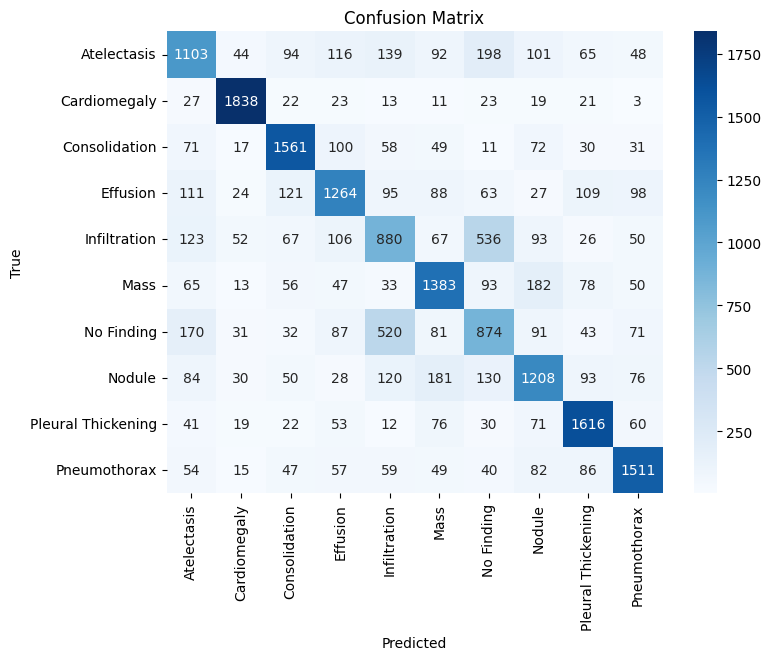

In [ ]:
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_labels, final_predictions, target_names=class_labels)
print(report)

cm = confusion_matrix(true_labels, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix')
plt.show()

#### Hard Voting (Majority Voting)

In [ ]:
from scipy.stats import mode

In [ ]:
predictions_vgg19 = np.argmax(model_vgg19.predict(test_generator, steps=test_generator.samples // test_generator.batch_size), axis=1)
predictions_vgg19_tl = np.argmax(model_vgg19_tl.predict(test_generator, steps=test_generator.samples // test_generator.batch_size), axis=1)
predictions_resnet50 = np.argmax(model_resnet50.predict(test_generator, steps=test_generator.samples // test_generator.batch_size), axis=1)

# Stack the predictions into a matrix
stacked_predictions = np.stack((predictions_vgg19, predictions_vgg19_tl, predictions_resnet50))

final_predictions = mode(stacked_predictions, axis=0)[0].flatten()

# Generate the accuracy
ensemble_accuracy = accuracy_score(true_labels, final_predictions)
print(f'Hard Voting Ensemble Model Accuracy: {ensemble_accuracy}')

2500/2500 [==============================] - 54s 22ms/step
Hard Voting Ensemble Model Accuracy: 0.62505


                    precision    recall  f1-score   support

       Atelectasis       0.44      0.64      0.52      2000
      Cardiomegaly       0.81      0.92      0.86      2000
     Consolidation       0.64      0.76      0.70      2000
          Effusion       0.60      0.61      0.60      2000
      Infiltration       0.41      0.41      0.41      2000
              Mass       0.66      0.65      0.66      2000
        No Finding       0.45      0.35      0.39      2000
            Nodule       0.69      0.52      0.59      2000
Pleural Thickening       0.82      0.72      0.77      2000
      Pneumothorax       0.83      0.67      0.74      2000

          accuracy                           0.63     20000
         macro avg       0.63      0.63      0.62     20000
      weighted avg       0.63      0.63      0.62     20000



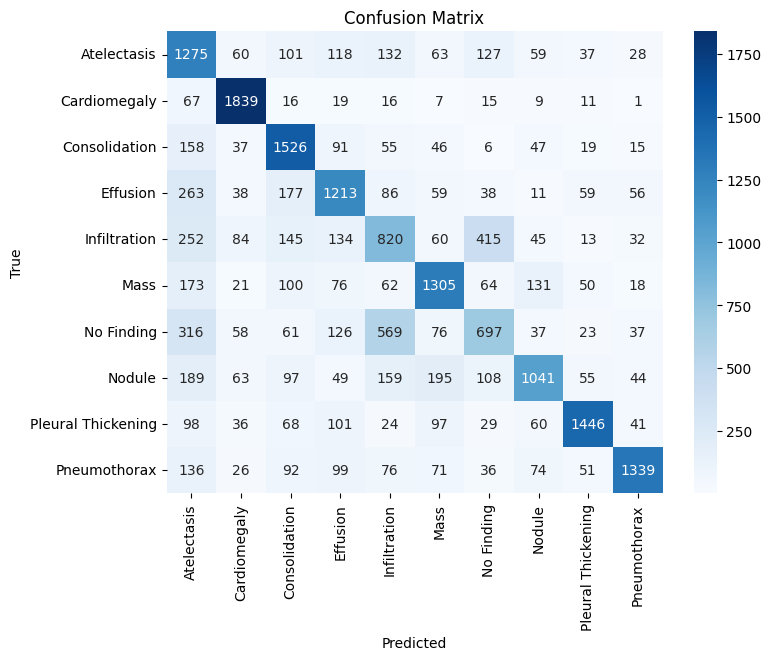

In [ ]:
report = classification_report(true_labels, final_predictions, target_names=class_labels)
print(report)

cm = confusion_matrix(true_labels, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix')
plt.show()